In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import time
import itertools
import joblib

from jsonschema.exceptions import relevance
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier, LinearRegression
from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif

In [9]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i)

    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

def return_data(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test


In [10]:
df = fetch_data('SPY', '2015-01-01', '2023-12-31')


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_1908/3726022310.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [20]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_01', train_frac=0.8, features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

# Model setup
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_reg = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_reg, 'MSE': mean_squared_error}

model_regression = LogisticRegression(w, b, optimizer)

# Train the model
metrics_history = model_regression.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)
joblib.dump((model_regression, metrics_history, X_test, Y_test, X, df), "regression_model_outputs.pkl")


['regression_model_outputs.pkl']

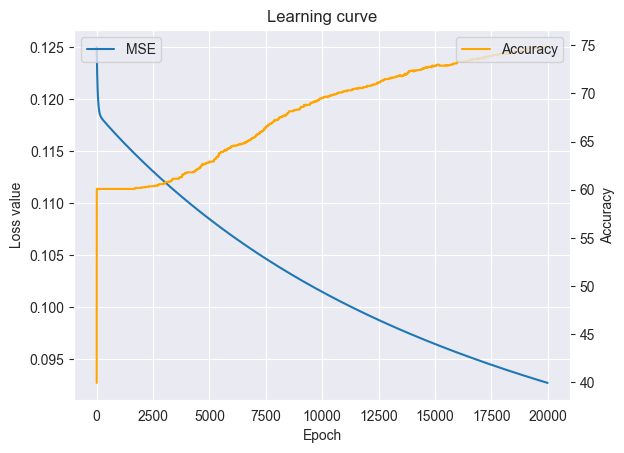

The final train accuracy: 74.83%
Test accuracy: 84.19%


In [23]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Plot learning curve
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

# Evaluation
print(f'The final train accuracy: {metrics_history["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_reg(model_regression.decision_function(X_test), Y_test):.2f}%')



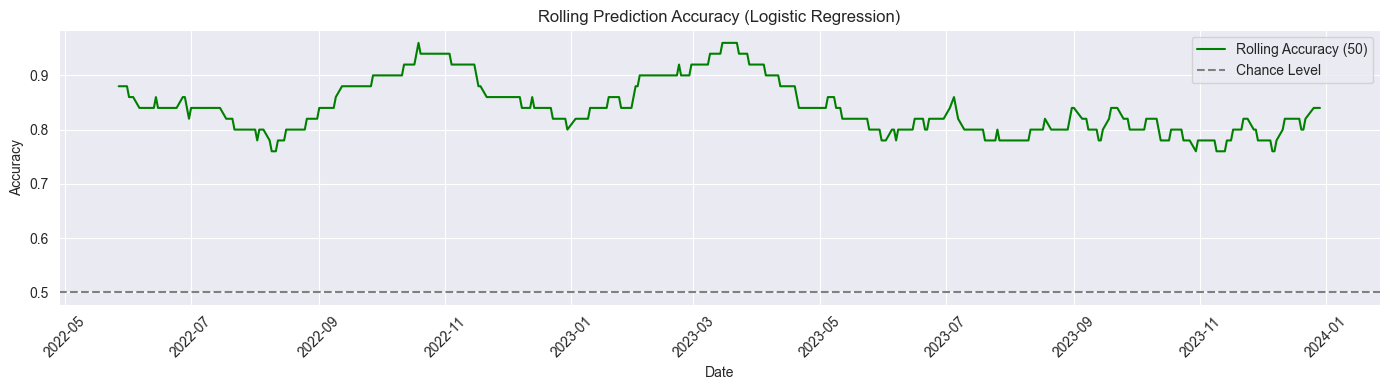

In [22]:
# --- Rolling window accuracy plot (with real dates) ---
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Extract aligned dates from original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# Use same logic to align Date with test set
date_series = df_copy['Date'].iloc[-len(X):].values
split_idx = int(len(X) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = model_regression(X_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (Logistic Regression)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_-1',train_frac=.8,features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
kernels = ['linear', 'polynomial', 'rbf']
for i in range(10):
    start = time.time()
    svm_poly = BinaryKernelSVM(kernel='polynomial', degree=i)
    svm_poly.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_poly(X_test), Y_test)

    train_acc = binary_accuracy(svm_poly(X_train), Y_train)

    print(f'Test accuracy degree {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")

sigma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
for i in sigma_values:
    start = time.time()
    svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=i)
    svm_rbf.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_rbf(X_test), Y_test)

    train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

    print(f'Test accuracy sigma {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")


Test accuracy degree 0: 55.0111, Train accuracy: 60.0780
⏱️ Train time: 4.9842 seconds
Test accuracy degree 1: 68.3742, Train accuracy: 84.1871
⏱️ Train time: 4.9687 seconds
Test accuracy degree 2: 55.9020, Train accuracy: 90.1448
⏱️ Train time: 5.4456 seconds
Test accuracy degree 3: 55.6793, Train accuracy: 91.9265
⏱️ Train time: 5.8341 seconds
Test accuracy degree 4: 54.7884, Train accuracy: 92.6503
⏱️ Train time: 5.5382 seconds
Test accuracy degree 5: 57.9065, Train accuracy: 92.9844
⏱️ Train time: 5.2475 seconds
Test accuracy degree 6: 61.9154, Train accuracy: 94.1537
⏱️ Train time: 6.0378 seconds
Test accuracy degree 7: 61.9154, Train accuracy: 94.3764
⏱️ Train time: 6.1044 seconds
Test accuracy degree 8: 57.6837, Train accuracy: 89.9777
⏱️ Train time: 7.3935 seconds
Test accuracy degree 9: 59.2428, Train accuracy: 91.2027
⏱️ Train time: 7.8236 seconds
Test accuracy sigma 0.01: 55.0111, Train accuracy: 100.0000
⏱️ Train time: 3.4200 seconds
Test accuracy sigma 0.05: 55.0111, Train

Test accuracy sigma 1: 74.3875, Train accuracy: 82.9621


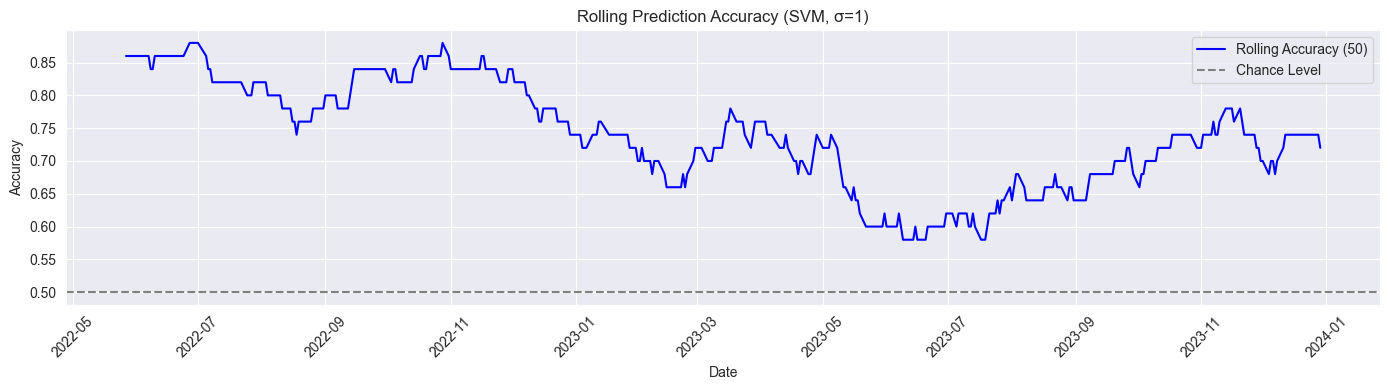

In [92]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_-1', train_frac=0.8, features='whole')
X_train = min_max(X_train)
X_test = min_max(X_test)
X = min_max(X)

# Train model
svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=1)
svm_rbf.fit(X_train, Y_train)

# Evaluate
test_acc = binary_accuracy(svm_rbf(X_test), Y_test)
train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

print(f'Test accuracy sigma {1}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

# --- Rolling accuracy visualization ---

# Get the corresponding dates from the original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()  # Ensure 'Date' is a column
df_copy.dropna(inplace=True)

# Align dates with final feature set
date_series = df_copy['Date'].iloc[-len(X):].values
split_idx = int(len(X) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = svm_rbf(X_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='blue', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (SVM, σ=1)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_-1',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

Y, Y_train, Y_test = labels_encoding(Y), labels_encoding(Y_train), labels_encoding(Y_test)

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}


optimizer = GDOptimizer(learning_rate=1)

model = MLP(widths=[14, 64,32, 2], optimizer=optimizer, activation='ReLU', output_activation='Linear', loss='MSE')

metrics_history = model.fit(X_train, Y_train, num_epochs=15000, batch_size=len(X_train), compute_metrics=True,
                            metrics_dict=metrics_dict)

joblib.dump((model, metrics_history, X_test, Y_test, X, df), "mlp_model_outputs.pkl")



['mlp_model_outputs.pkl']

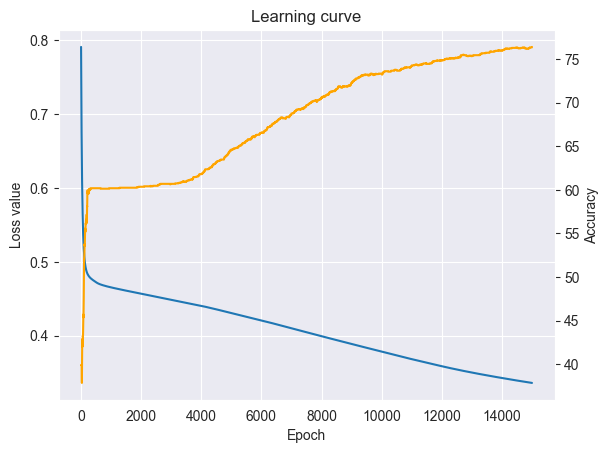

The final train accuracy: 76.4%
Test accuracy: 23.9%


In [14]:
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {round(metrics_history["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test), 1)}%')



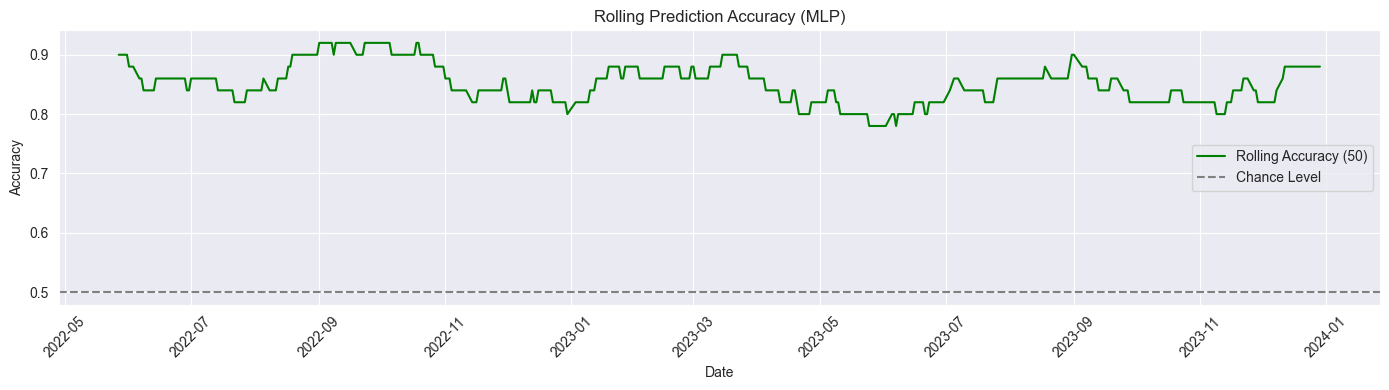

In [18]:
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
Y_pred = model(X_test)

# Convert predictions to class labels (assuming sigmoid-like output around 0)
if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_test.flatten() if Y_test.ndim == 1 else Y_test.argmax(axis=1)
else:
    # Multiclass (e.g. shape [n_samples, 2])
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_test, axis=1)
    


# Get test dates
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# Extract test dates
test_dates = df_copy['Date'].iloc[-len(X_test):].values

# Build result DataFrame
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (MLP)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_01',train_frac=.8,features = 'lagged')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy, 'MSE': mean_squared_error}

model = LinearRegression(w, b, optimizer)

metrics_history = model.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)

joblib.dump((model, metrics_history, X_test, Y_test, X, df), "lag_model_outputs.pkl")

['lag_model_outputs.pkl']

Final train accuracy (baseline): 67.00%
Test accuracy (baseline): 71.68%


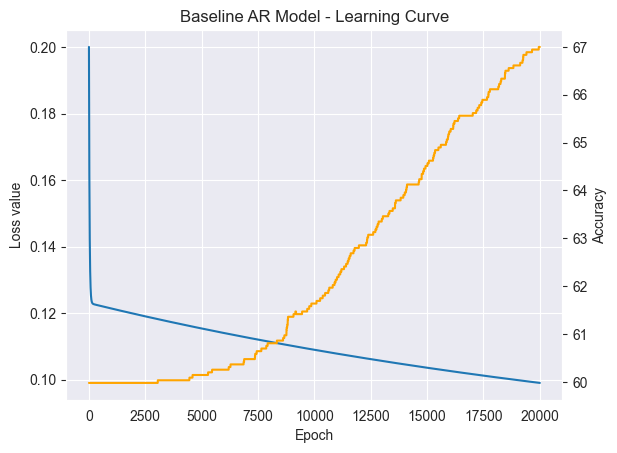

In [25]:
# Plot metrics
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("lag_model_outputs.pkl")
fig, ax = plt.subplots()
ax.plot(metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
plt.title('Baseline AR Model - Learning Curve')
plt.grid()

# Final metrics
train_acc = metrics_history["accuracy"][-1]
test_acc = accuracy(model.decision_function(X_test), Y_test)

print(f'Final train accuracy (baseline): {train_acc :.2f}%')
print(f'Test accuracy (baseline): {test_acc :.2f}%')

plt.show()